In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#resize

In [ ]:
# this code tries to convert the fall and not-fall videos to the desired form which is 20*15-sized-frame videos, then it saves the new movies in another folder

import numpy as np 
import cv2
import os; import glob
import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

def resize(first_folder,target_folder):

       	fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        
       	vid_num=0
       
        videos = glob.glob(first_folder+"/*.avi")     #reading videos of the first folder
        videos.sort(key=natural_keys)
        for i,vid in (enumerate(videos)):
           vid_num+=1           
           cap = cv2.VideoCapture(vid)
           num_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
           framerate = cap.get(cv2.CAP_PROP_FPS)
           out = cv2.VideoWriter('{}/video_{}.avi'.format(target_folder,vid_num),fourcc, framerate, (112,112),True)   #creating the resized video
           for i in range(0, num_frame+1):
               ret, frame=cap.read()
               if ret==True:
                   if i==0:
                        r,c,_ = frame.shape # here the biggest square in the middle of frame is cropped
                        d = (c-r)//2
                        sc = d
                        ec = r+d
                   resizedfram = cv2.resize(frame[:, sc:ec], (112,112), interpolation = cv2.INTER_AREA)
                   out.write(resizedfram)
               else:
                   out.release()
                   break
#-------------------------resize data set with the defined function named resize which receives the lower part files path and resize the movies in the directory to 15*20 movies in the new directory path which also should be received as one of the inputs------------------------------
# resize(r"/content/drive/MyDrive/openpose/circle/org/Coffee_room_01",r"/content/drive/MyDrive/openpose/circle/original/Coffee_room_01")


#libs


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv3D, MaxPooling3D, ZeroPadding3D

def create_model_sequential():
    """ Creates model object with the sequential API:
    https://keras.io/models/sequential/
    """

    model = Sequential()
    input_shape = (16, 112, 112, 3)

    model.add(Conv3D(64, (3, 3, 3), activation='relu',
                     padding='same', name='conv1',
                     input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2),
                           padding='valid', name='pool1'))
    # 2nd layer group
    model.add(Conv3D(128, (3, 3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool2'))
    # 3rd layer group
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3a'))
    model.add(Conv3D(256, (3, 3, 3), activation='relu',
                     padding='same', name='conv3b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool3'))
    # 4th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv4b'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool4'))
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool5'))
    model.add(Flatten(name='flat5'))
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6'))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='softmax', name='fc8'))

    return model



In [ ]:
import numpy as np
ar = np.array
import cv2
import pickle
from sklearn import svm
from scipy.signal import find_peaks
import os; import glob
from tensorflow.python.keras import layers, models
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Dense
from keras.constraints import maxnorm
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

c3d_len = 16

def load_c3d():                       # defining C3D network

    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    model = create_model_sequential()
    try:
        model.load_weights('/content/drive/MyDrive/C3D_Sport1M_weights_keras_2.2.4.h5')   #weights of the network should be downloaded 
    except OSError as err:
        print('Check path to the model weights\' file!\n\n', err)
    except :
        print("errooooor")

    C3D = Model(inputs=model.input,
                      outputs=[ model.get_layer('fc6').output,
                               model.get_layer('flat5').output,
                               model.get_layer('fc7').output,
                               model.get_layer('fc8').output])
    CNN_FC5 = models.Model(inputs=C3D.inputs, outputs=C3D.layers[-6].output)          # defining a network only with the convolution part of the C3D network (essential for training the FCN)
    CNN_FC5.summary()
    del model
    return CNN_FC5

CNN_FC5=load_c3d()
new_train=False



ValueError: ignored

In [ ]:
from tqdm import tqdm               
        
        
# ===========================
def ext(l,c3d):                 # This function gives the result of c3d network for the given input frames
    
    frames16 = l[:16].reshape((1,16,112,112,3)).astype('int') -100 # .astype('int')*255
    features_4layers = c3d.predict(frames16)
    return features_4layers



class extraction():                 # This class returns extracted features and their labels
    def __init__(self, dataset_name, options, label,ds_addr,data_addr):
        self.ds_addr = ds_addr;             # address of the dataset location
        self.data_addr = data_addr;         # address of the extracted features
        self.dataset_name = dataset_name;   # name of the folder
        self.label = label
        self.options = options
        self.dsrate = options['downsample_rate']
        self.stride = options['stride'] 

    def extract(self):
        print(self.label, "extracting ...")
        if self.dataset_name not in os.listdir(self.ds_addr):
            print("error , folder with dataset_name was not found\n\n")
  
            
        f = open(self.ds_addr+ self.dataset_name+'/'+self.dataset_name+'.txt', "r+")
        annot = f.readlines()                                                                 # reading lines of each text file
        
        self.annot=[]
        f.close()
        videos = glob.glob(self.ds_addr+ self.dataset_name+'/*.avi')                          #reading videos of the dataset folder
        videos.sort(key=natural_keys)        
        CNN_FC5=load_c3d()                                                                    # loading only the convolution part of the C3D network

        fc5_n=[]; fc5_o=[]; labels_n=[]; labels_o=[];
        for j,video in (enumerate(videos)):                                  

            start=int(annot[j].split()[0])
            end=int(annot[j].split()[1])
            f_all=int(annot[j].split()[2])

            capture = cv2.VideoCapture( video )
            num_frame = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

            if f_all!=num_frame:
                print("error, num frames", num_frame,f_all)
            if not capture.isOpened:
                print('Unable to open: ' + inp)
                exit(0)
            
            frame16= []
            i=0
            for i in range(0, num_frame):
                ret, frame = capture.read()
                    
                if i% self.dsrate==0:                                     # applying downsampling to the frames
                    frame_resized=frame
                    frame16 += [frame_resized]
                if frame is None:
                    break
        #============================================
            frame16 = ar(frame16)
            c3dlength = 16
            if len(frame16)<16 :
                print("error... not enough frames")
                continue
            sample_number = (len(frame16)-c3dlength)// self.stride +1       # calculating the number of input segments         
            for k in range(sample_number):
                sc=k*self.stride; ec=k*self.stride+16                       # applying stride to the frames
                xn = ext(frame16[sc:ec],CNN_FC5)
                fc5_n+=[xn]
                if start==0 and end==0:
                  label=[0,1]   
                elif (sc*self.dsrate)>=start and (ec*self.dsrate)<=end:
                  label=[1,0]
                else:
                  label=[0,1]      
                labels_n+=[label]
                

        self.fc5_n=fc5_n
        print(np.shape(fc5_n))
        np.save(self.data_addr +"/{}_fc5.npy".format(self.dataset_name),fc5_n)
        np.save(self.data_addr +"/{}_labels.npy".format(self.dataset_name),labels_n)
        return fc5_n,labels_n
        


#Extracting FC5

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA

from tensorflow.python.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tqdm import tqdm
ar = np.array
new_train=False
# !rm -rf '/content/drive/MyDrive/full_frame/data/conv4/original/'
# !mkdir '/content/drive/MyDrive/full_frame/data/conv4/original/'
ds_addr= '/content/drive/MyDrive/full_frame/cross_subject/original/'
data_addr = '/content/drive/MyDrive/full_frame/data/conv4/original/'
options={'downsample_rate':1 , 'background_sub':False, 'stride':4}


# datasets=[['Home_01','Home_02','Office','Office2','Coffee_room_01','ur_fall','ur_adl','Lecture_room','mine','mine_fall']]
datasets=[['train']]
for j,folder in (enumerate(datasets)):

  for i,name in (enumerate(folder)):
      try:
        fc5_n=np.load(data_addr+"/{}_fc5.npy".format(name))
        labels_n=np.load(data_addr+"/{}_labels.npy".format(name))
        print("{} loaded successfully".format(name))
      except:
        ds=extraction(name, options , name,ds_addr,data_addr)
      
        fc5_n,labels_n=ds.extract()
        fc5_n=ar(fc5_n); labels_n=ar(labels_n)  
      if i==0:
        if len(fc5_n)!=0:
          fc5n_all=fc5_n
          labelsn_all=labels_n
      else:
        if len(fc5_n)!=0:
          fc5n_all=np.concatenate((fc5n_all,fc5_n),axis=0)
          labelsn_all=np.concatenate((labelsn_all,labels_n),axis=0)
        
     
##################################################reshaping fc5 and labels_all for network ###################################

fc5n_all=np.reshape(fc5n_all,(-1,2, 7, 7, 512) ) 

size=np.size(labelsn_all); size=int(size/2)
labelsn_all=ar(labelsn_all)
labelsn_all=np.reshape(labelsn_all,(size,2))
Xntrain=fc5n_all; Yntrain=labelsn_all
del fc5n_all,labelsn_all
# datasets=[['Home_01','Home_02','Office','Office2','Coffee_room_01','ur_fall','ur_adl','Lecture_room','mine','mine_fall']]
datasets=[['test']]
for j,folder in (enumerate(datasets)):

  for i,name in (enumerate(folder)):
      try:
        fc5_n=np.load(data_addr+"/{}_fc5.npy".format(name))
        labels_n=np.load(data_addr+"/{}_labels.npy".format(name))
        print("{} loaded successfully".format(name))
      except:
        ds=extraction(name, options , name,ds_addr,data_addr)
      
        fc5_n,labels_n=ds.extract()
        fc5_n=ar(fc5_n); labels_n=ar(labels_n)  
      if i==0:
        if len(fc5_n)!=0:
          fc5n_all=fc5_n
          labelsn_all=labels_n
      else:
        if len(fc5_n)!=0:
          fc5n_all=np.concatenate((fc5n_all,fc5_n),axis=0)
          labelsn_all=np.concatenate((labelsn_all,labels_n),axis=0)
        
     
##################################################reshaping fc5 and labels_all for network ###################################
fc5n_all=np.reshape(fc5n_all,(-1,2, 7, 7, 512) ) 

size=np.size(labelsn_all); size=int(size/2)
labelsn_all=ar(labelsn_all)
labelsn_all=np.reshape(labelsn_all,(size,2))
Xnvalid=fc5n_all; Ynvalid= labelsn_all
del fc5n_all,labelsn_all

train extracting ...


KeyboardInterrupt: ignored

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA

from tensorflow.python.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tqdm import tqdm
ar = np.array
!rm -rf '/content/drive/MyDrive/full_frame/data/conv4/openpose/'
!mkdir '/content/drive/MyDrive/full_frame/data/conv4/openpose/'
ds_addr= '/content/drive/MyDrive/full_frame/cross_subject/openpose/'
data_addr = '/content/drive/MyDrive/full_frame/data/conv4/openpose/'
options={'downsample_rate':1 , 'background_sub':False, 'stride':16}

# datasets=[['Home_01','Home_02','Office','Office2','Coffee_room_01','ur_fall','ur_adl','Lecture_room','mine']]
datasets=[['train']]
for j,folder in (enumerate(datasets)):

  for i,name in (enumerate(folder)):
      try:
        fc5_o=np.load(data_addr+"/{}_fc5.npy".format(name))
        labels_o=np.load(data_addr+"/{}_labels.npy".format(name))
        print("{} loaded successfully".format(name))
      except:
        ds=extraction(name, options , name,ds_addr,data_addr)
      
        fc5_o,labels_o=ds.extract()
        fc5_o=ar(fc5_o);  labels_o=ar(labels_o)     
      if i==0:
        if len(fc5_o!=0):
          fc5o_all=fc5_o
          labelso_all=labels_o

      else:
        if len(fc5_o!=0):
          fc5o_all=np.concatenate((fc5o_all,fc5_o),axis=0)
          labelso_all=np.concatenate((labelso_all,labels_o),axis=0)    
##################################################reshaping fc5 and labels_all for network ###################################

d1,d2,d3=np.shape(fc5o_all)
fc5o_all=np.reshape(fc5o_all,(d1,d3)) 

size=np.size(labelso_all); size=int(size/2)
labelso_all=ar(labelso_all)
labelso_all=np.reshape(labelso_all,(size,2))
Xotrain=fc5o_all; Yotrain= labelso_all
del fc5o_all,labelso_all

datasets=[['test']]
for j,folder in (enumerate(datasets)):

  for i,name in (enumerate(folder)):
      try:
        fc5_o=np.load(data_addr+"/{}_fc5.npy".format(name))
        labels_o=np.load(data_addr+"/{}_labels.npy".format(name))
        print("{} loaded successfully".format(name))
      except:
        ds=extraction(name, options , name,ds_addr,data_addr)
      
        fc5_o,labels_o=ds.extract()
        fc5_o=ar(fc5_o);  labels_o=ar(labels_o)     
      if i==0:
        if len(fc5_o!=0):
          fc5o_all=fc5_o
          labelso_all=labels_o

      else:
        if len(fc5_o!=0):
          fc5o_all=np.concatenate((fc5o_all,fc5_o),axis=0)
          labelso_all=np.concatenate((labelso_all,labels_o),axis=0)
        
     
##################################################reshaping fc5 and labels_all for network ###################################

d1,d2,d3=np.shape(fc5o_all)
fc5o_all=np.reshape(fc5o_all,(d1,d3)) 

size=np.size(labelso_all); size=int(size/2)
labelso_all=ar(labelso_all)
labelso_all=np.reshape(labelso_all,(size,2))

Xovalid=fc5o_all; Yovalid= labelso_all
del fc5o_all,labelso_all
    #####################################################################################################    
# print(np.shape(fc5n_all),np.shape(labelsn_all),np.shape(fc5o_all),np.shape(labelso_all))
# Xn2, Xntest, Yn2,Yntest = train_test_split(fc5n_all, labelsn_all, test_size=0.2, random_state=42 )
# Xntrain, Xnvalid, Yntrain,Ynvalid = train_test_split(Xn2, Yn2, test_size=0.2 , random_state=42) 
# print("Normal Xtrain is:",np.shape(Xntrain),"          Normal Xvalid is:",np.shape(Xnvalid),"          Normal Xtest is:",np.shape(Xntest))   
# print("Normal Ytrain is:",np.shape(Yntrain),"          Normal Yvalid is:",np.shape(Ynvalid),"          Normal Ytest is:",np.shape(Yntest))    
# del fc5n_all,labelsn_all,Xn2,Yn2     
    #####################################################################################################  

# Xo2, Xotest, Yo2,Yotest = train_test_split(fc5o_all, labelso_all, test_size=0.2, random_state=42 )
# Xotrain, Xovalid, Yotrain,Yovalid = train_test_split(Xo2, Yo2, test_size=0.2 , random_state=42) 
# print("Occluded Xtrain is:",np.shape(Xotrain),"          Occluded Xvalid is:",np.shape(Xovalid),"          Occluded Xtest is:",np.shape(Xotest))   
# print("Occluded Ytrain is:",np.shape(Yotrain),"          Occluded Yvalid is:",np.shape(Yovalid),"          Occluded Ytest is:",np.shape(Yotest))  
# del fc5o_all,labelso_all,Xo2,Yo2         
    ##################################################################################################### 

Xtrain=np.concatenate((Xntrain,Xotrain),axis=0);  Ytrain=np.concatenate((Yntrain,Yotrain),axis=0)
maximum=np.amax(Xtrain); Xntrain=Xntrain/maximum; Xotrain=Xotrain/maximum
# Xtest=np.concatenate((Xntest,Xotest),axis=0);     Ytest=np.concatenate((Yntest,Yotest),axis=0)
Xvalid=np.concatenate((Xnvalid,Xovalid),axis=0);     Yvalid=np.concatenate((Ynvalid,Yovalid),axis=0)
maximum=np.amax(Xvalid); Xovalid=Xovalid/maximum; Xnvalid=Xnvalid/maximum; Xvalid=Xvalid/maximum
# Xvalid, Xtest, Yvalid,Ytest = train_test_split(Xvalid, Yvalid, test_size=0.5)
    ##################################################################################################### 

# fc_all=np.concatenate((fc5n_all,fc5o_all),axis=0)
# labels_all=np.concatenate((labelsn_all,labelso_all),axis=0)

# print(np.shape(fc_all),np.shape(labels_all))
# X2, Xtest, Y2,Ytest = train_test_split(fc_all, labels_all, test_size=0.3, random_state=42 )
# Xtrain, Xvalid, Ytrain,Yvalid = train_test_split(X2, Y2, test_size=0.2 , random_state=42) 
#     ##################################################################################################### 

# print("Xtrain is:",np.shape(Xtrain),"          Xvalid is:",np.shape(Xvalid),"          Xtest is:",np.shape(Xtest))   
# print("Ytrain is:",np.shape(Ytrain),"          Yvalid is:",np.shape(Yvalid),"          Ytest is:",np.shape(Ytest))  



In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA

from tensorflow.python.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tqdm import tqdm
ar = np.array

# !rm -rf '/content/drive/MyDrive/yolo/data/flatten/openpose/'
# !mkdir '/content/drive/MyDrive/yolo/data/flatten/openpose/'
ds_addr= '/content/drive/MyDrive/yolo/original/'
data_addr = '/content/drive/MyDrive/yolo/data/flatten/original/'
options={'downsample_rate':1 , 'background_sub':False, 'stride':4}


# datasets=[['Home_01','Home_02','Office','Office2','Coffee_room_01','ur_fall','ur_adl','Lecture_room','mine','mine_fall']]
datasets=[['mine2','mine','mine_fall']]
for j,folder in (enumerate(datasets)):

  for i,name in (enumerate(folder)):
      try:
        fc5_n=np.load(data_addr+"/{}_fc5.npy".format(name))
        labels_n=np.load(data_addr+"/{}_labels.npy".format(name))
        print("{} loaded successfully".format(name))
      except:
        ds=extraction(name, options , name,ds_addr,data_addr)
      
        fc5_n,labels_n=ds.extract()
        fc5_n=ar(fc5_n); labels_n=ar(labels_n)  
      if i==0:
        if len(fc5_n)!=0:
          fc5n_all=fc5_n
          labelsn_all=labels_n
      else:
        if len(fc5_n)!=0:
          fc5n_all=np.concatenate((fc5n_all,fc5_n),axis=0)
          labelsn_all=np.concatenate((labelsn_all,labels_n),axis=0)
        
     
##################################################reshaping fc5 and labels_all for network ###################################
d1,d2,d3=np.shape(fc5n_all)
fc5n_all=np.reshape(fc5n_all,(d1,d3)) 

size=np.size(labelsn_all); size=int(size/2)
labelsn_all=ar(labelsn_all)
labelsn_all=np.reshape(labelsn_all,(size,2))
Xntest=fc5n_all; Yntest=labelsn_all
del fc5n_all,labelsn_all

ds_addr= '/content/drive/MyDrive/openpose/circle/yolo_10/'
data_addr = '/content/drive/MyDrive/yolo/data/flatten/openpose/'
options={'downsample_rate':1 , 'background_sub':False, 'stride':16}

datasets=[['mine','mine_fall']]
for j,folder in (enumerate(datasets)):

  for i,name in (enumerate(folder)):
      try:
        fc5_n=np.load(data_addr+"/{}_fc5.npy".format(name))
        labels_n=np.load(data_addr+"/{}_labels.npy".format(name))
        print("{} loaded successfully".format(name))
      except:
        ds=extraction(name, options , name,ds_addr,data_addr)
      
        fc5_n,labels_n=ds.extract()
        fc5_n=ar(fc5_n); labels_n=ar(labels_n)  
      if i==0:
        if len(fc5_n)!=0:
          fc5n_all=fc5_n
          labelsn_all=labels_n
      else:
        if len(fc5_n)!=0:
          fc5n_all=np.concatenate((fc5n_all,fc5_n),axis=0)
          labelsn_all=np.concatenate((labelsn_all,labels_n),axis=0)
        
     
##################################################reshaping fc5 and labels_all for network ###################################
d1,d2,d3=np.shape(fc5n_all)
fc5n_all=np.reshape(fc5n_all,(d1,d3)) 

size=np.size(labelsn_all); size=int(size/2)
labelsn_all=ar(labelsn_all)
labelsn_all=np.reshape(labelsn_all,(size,2))
Xotest=fc5n_all; Yotest= labelsn_all
del fc5n_all,labelsn_all
Xtest=np.concatenate((Xntest,Xotest),axis=0);     Ytest=np.concatenate((Yntest,Yotest),axis=0)
maximum=np.amax(Xtest); Xtest=Xtest/maximum


#training fcn

{0: 13.645222929936306, 1: 0.5617526746381372}
{0: 13.647316992381583, 1: 0.5617420291633434}
number of iteration is:     0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


3/3 [==============================] - 4s 916ms/step - loss: 1.3868 - accuracy: 0.4722 - val_loss: 0.7173 - val_accuracy: 0.1142

Epoch 00001: val_loss improved from inf to 0.71733, saving model to /content/drive/MyDrive/biased_weights_10.hdf5
7/7 [==============================] - 5s 732ms/step - loss: 1.2934 - accuracy: 0.1247 - val_loss: 0.8650 - val_accuracy: 0.1142

Epoch 00001: val_loss did not improve from 0.71733
number of iteration is:     1
3/3 [==============================] - 2s 846ms/step - loss: 1.1798 - accuracy: 0.1099 - val_loss: 0.9642 - val_accuracy: 0.1142

Epoch 00001: val_loss did not improve from 0.71733
7/7 [==============================] - 5s 731ms/step - loss: 1.0935 - accuracy: 0.1099 - val_loss: 1.2495 - val_accuracy: 0.1142

Epoch 00001: val_loss did not improve from 0.71733
number of iteration is:     2
3/3 [==============================] - 3s 864ms/step - loss: 1.0835 - accuracy: 0.1099 - val_loss: 1.3484 - val_accuracy: 0.1142

Epoch 00001: val_loss d

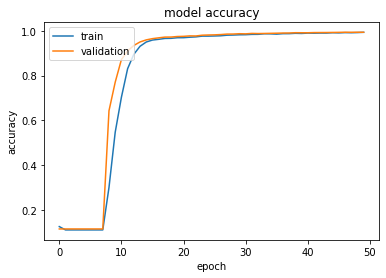

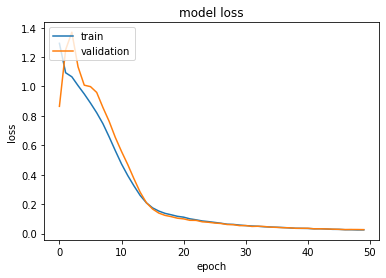

In [ ]:
def fcn():             # creating fully connected part of C3D network for training

    model = Sequential()
    input_shape = (2, 7, 7, 512) 
    # 5th layer group
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5a'))
    model.add(Conv3D(512, (3, 3, 3), activation='relu',
                     padding='same', name='conv5b'))
    model.add(ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2),
                           padding='valid', name='pool5'))
    model.add(Flatten(name='flat5'))
    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6',input_dim=input_shape))
    model.add(Dropout(.6))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.6))
    model.add(Dense(487, activation='relu', name='fc7_2'))
    model.add(Dropout(.5))
    model.add(Dense(2, activation='softmax', name='fc8'))
    return model

# fcn_nt=fcn()
# fcn_nt.summary()
######################################################################################################################

from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(Yntrain, axis=1)
class_weights_n = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights_n = dict(enumerate(class_weights_n))
a = d_class_weights_n[0]; a=3*a
d_class_weights_n[0]=a
type(d_class_weights_n[1])
print(d_class_weights_n)

y_integers = np.argmax(Yotrain, axis=1)
class_weights_o = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights_o = dict(enumerate(class_weights_o))
a = d_class_weights_o[0]; a=3*a
d_class_weights_o[0]=a
type(d_class_weights_o[1])
print(d_class_weights_o)
##########################################################################################################
epochs=1
n=len(Xntrain)
o=len(Xotrain)
ratio=(n/o)
lamda=0.805


batch_size=8192
momentom=0.937
i_iteration=50
lr=0.01
##########################################################################################################
output=[]
for gam in range(40,41,1):
    lamda=gam/100
    rrr=lamda*ratio
    sgd = SGD(lr=lr, momentum=momentom, nesterov=True)
    optimizer =Adam(lr=lr,beta_1=momentom) 
    fcn_nt=fcn()
    fcn_nt.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

    #########################################################################################################################3

    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    checkpoint = ModelCheckpoint("/content/drive/MyDrive/biased_weights_10.hdf5", monitor='val_loss',
                                verbose=1, save_best_only=True, save_weights_only=True,
                                mode='auto', period=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0,
                          patience=100, verbose=1, mode='auto',restore_best_weights=True)
    ########################repeat two steps for number of iteration times
    result=[]
    for i in range(i_iteration):
        print("number of iteration is:    ",i)
        ###############################first train the last layer with normal loss
        learning_rate=lr
        for layer in fcn_nt.layers[:]:
            layer.trainable = True
        
        history = fcn_nt.fit(x=Xntrain, y=Yntrain,
                            validation_data=(Xvalid, Yvalid),
                            class_weight = d_class_weights_n,
                            batch_size=batch_size,
                            epochs=epochs,
                             verbose=1,callbacks=[checkpoint,early])     #[checkpoint,early] [early]  
        
        ################################# now train the rest of the network with total loss
        learning_rate=rrr*lr                  #changing lr to reduce the loss of occluded data
        # fcn_nt.layers[-4].trainable = False
        # fcn_nt.layers[-3].trainable = False
        # fcn_nt.layers[-2].trainable = False
        # fcn_nt.layers[-1].trainable = False
        history = fcn_nt.fit(x=Xotrain, y=Yotrain,
                            validation_data=(Xvalid, Yvalid),
                            class_weight = d_class_weights_o,
                            batch_size=batch_size,
                            epochs=epochs,
                             verbose=1,callbacks=[checkpoint,early])     #[checkpoint,early] [early]                      
        accuracy=history.history['accuracy']; val_accuracy=history.history['val_accuracy']
        loss=history.history['loss']; val_loss=history.history['val_loss']
        result.append([accuracy,val_accuracy,loss,val_loss])
    result=np.array(result)
    val_loss=min(result[:,-1])[0]
    output.append([val_loss,lamda])
#########################################################################################here we calculate test loss and accuracy
from sklearn.metrics import classification_report, confusion_matrix
score = fcn_nt.evaluate(Xtest, Ytest, verbose=False) 
fcn_nt.metrics_names
print('Test loss: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])

########################################################here we claculate classification report and confusion matrix of test data
Ytest_pred=ar(fcn_nt.predict(Xtest))
targ=[]
for i in range(len(Ytest_pred)):
  if Ytest_pred[i,0]>Ytest_pred[i,1]:
    targ+=[1]
  else:
    targ+=[0]
Ytest=ar(Ytest)
Ytest2=Ytest[:,0]

print("classification_report:\n",classification_report(Ytest2, targ, labels=[0,1]))
print("confusion_matrix:\n",confusion_matrix(Ytest2, targ))
# list all data in history
# print(result.history.keys())
# summarize history for accuracy
result=np.array(result)
result=np.reshape(result,(-1,4))
import matplotlib.pyplot as plt
plt.plot(result[:,0])
plt.plot(result[:,1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(result[:,2])
plt.plot(result[:,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#getting final results

In [ ]:

def fcn():
    """ Creates model object with the sequential API:
    https://keras.io/models/sequential/
    """

    model = Sequential()
    input_shape = 8192

    # FC layers group
    model.add(Dense(4096, activation='relu', name='fc6',input_dim=input_shape))
    model.add(Dropout(.5))
    model.add(Dense(4096, activation='relu', name='fc7'))
    model.add(Dropout(.5))
    model.add(Dense(487, activation='relu', name='fc7_2'))
    model.add(Dropout(.05))
    model.add(Dense(2, activation='softmax', name='fc8'))

    return model

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.layers.merge import concatenate


def load_fcn(fcn):             # defining the trained FCN 

    model = fcn()
    try:
        model.load_weights("/content/drive/MyDrive/biased_weights_10.hdf5")
    except OSError as err:
        print('Check path to the model weights\' file!\n\n', err)
    except :
        print("errooooor")
    fcn = Model(inputs=model.input,
                      outputs=[ model.get_layer('fc6').output,
                               model.get_layer('fc7').output,
                               model.get_layer('fc7_2').output,
                               model.get_layer('fc8').output])

    # fcn.summary()
    del model
    return fcn

# del Xtrain,Xtest,Xvalid,Ytrain,Ytest,Yvalid
# del Xntrain,Xntest,Xnvalid,Yntrain,Yntest,Ynvalid
# del Xotrain,Xotest,Xovalid,Yotrain,Yotest,Yovalid

#lib 2

In [ ]:
import numpy as np
ar = np.array
import cv2
import pickle
from sklearn import svm
from scipy.signal import find_peaks
import os; import glob
from tqdm import tqdm  
import re
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

c3d_len = 16
             
class extraction():                 # in class ham kollan feature exraction va label gozari anjam mide
    def __init__(self, dataset_name, options, label,ds_addr,data_addr):
        self.ds_addr = ds_addr; 
        self.data_addr = data_addr; 
        self.dataset_name = dataset_name; 
        self.label = label
        self.options = options
        self.dsrate = options['downsample_rate']
        self.stride = options['stride'] #2 # was 2 meaning 8 frame steps. # 2 when stride=4


    def load(self):                                               #this function either load feature-all or extract it
        if new_train==True:
          self.extract()
        else:
          try:
              filename =self.data_addr+ self.label
              infile = open(filename,'rb')
              self.features_all = pickle.load(infile)
              filename =self.data_addr+ self.label+'_labels'
              infile = open(filename,'rb')
              self.labels = pickle.load(infile)            
              infile.close()
              print(self.label, "loaded successfully")
          except:           
            self.extract()
                
    def extract(self):
        print(self.label, "extracting ...")
        if self.dataset_name not in os.listdir(self.ds_addr):
            print("error , folder with dataset_name was not found\n\n")             
        
        CNN_FC5 = load_c3d()                                                                    # loading only the convolution part of the C3D network 
        features_all = {}; labels=[]
        f = open(self.ds_addr+ self.dataset_name+'/'+self.dataset_name+'.txt', "r+")
        annot = f.readlines()                                                                 # reading lines of each text file
        f.close()
        videos = glob.glob(self.ds_addr+ self.dataset_name+'/*.avi')                          #reading videos of the dataset folder
        videos.sort(key=natural_keys)

        for i,video in (enumerate(videos)):                           
            # print(video, annot[i])
            capture = cv2.VideoCapture( video )
            start=int(annot[i].split()[0])
            end=int(annot[i].split()[1])
            f_all=int(annot[i].split()[2])
            num_frame = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            if f_all!=num_frame:
                print("error, num frames", num_frame,f_all)
            if not capture.isOpened:
                print('Unable to open: ' + inp)
                exit(0)
            
            frame16= []
            i=0
            for i in range(0, num_frame):
                # print(num_frame)
                ret, frame = capture.read()
                    
                if i% self.dsrate==0:                                     # applying downsampling to the frames
                    frame_resized=frame
                    frame16 += [frame_resized]
                if frame is None:
                    break
        #============================================
            frame16 = ar(frame16)
            c3dlength = 16
            if len(frame16)<16 :
                # print("error... not enough frames")
                continue
            sample_number = (len(frame16)-c3dlength)// self.stride +1       # calculating the number of input segments      
            
            features = []; count=0
            for i in range(sample_number):
                sc=i*self.stride; ec=i*self.stride+16                       # applying stride to the frames
                f = ext(frame16[sc:ec],CNN_FC5)
                features += [f]
                if start==0 and end==0:
                  label=-1
                elif (sc*self.dsrate)>=start and (ec*self.dsrate)<=end:
                  label=1
                  count+=1                 
                else:
                  label=-1     
                labels+=[label]
            # print(count)
            features_all.update({video:features})

        self.labels=(labels)
        self.features_all = features_all               
        filename =self.data_addr+ self.label
        outfile = open(filename,'wb')
        outfile_l=open(filename+'_labels','wb')
        pickle.dump(features_all ,outfile)
        pickle.dump(self.labels ,outfile_l)
        outfile.close()
        del CNN_FC5
        
    def load_layer(self,layer): # loads data of nth layer of C3D with labels.
        layer_features=[];
        for k,v in self.features_all.items():      
            layer_features +=[clipdata[layer] for clipdata in v]
        print(np.shape(np.array(layer_features)))
        return np.array(layer_features),self.labels    



#cross sample

In [ ]:
#this code tries to extract features using fcn of C3d and classify them with SVM
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.metrics import classification_report, confusion_matrix
ar = np.array
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# ===========================
new_train=False
# new_train=True
def ext(l,c3d):                 #this function first reshapes l into 16*112*112*3  then gives it to c3d to predict
    frames16 = l[:16].reshape((1,16,112,112,3)).astype('int') -100 # .astype('int')*255
    flt = c3d.predict(frames16)   
    features_4layers=fcn2.predict(flt)
    del flt
    return features_4layers

options={'downsample_rate':1 , 'background_sub':False, 'stride':2}
# datasets = [[['train'],['test']]]
# datasets = [[['mine','mine_fall'],['mine2']]]
datasets=[['Home_01','Home_02','Office','Office2','ur_fall','ur_adl','Lecture_room','Coffee_room_01','mine','mine_fall','mine2']]

layers = [0,1,2]
gridCV = {
    'C': [1,10,100],
    'gamma': [0.00001],
        }
for folder in datasets:
    layerscores = []        
    for layer in layers:
        print('\n Layer {}'.format(layer))
        fcn2=load_fcn(fcn)
        Xntrain=[]; Xntest = []
        Yntrain=[]; Yntest = []
        Xotrain=[]; Xotest = []
        Yotrain=[]; Yotest = []

        options={'downsample_rate':1 , 'background_sub':False, 'stride':2}
        ds_addr= '/content/drive/MyDrive/full_frame/cross_subject/original/'
        data_addr = '/content/drive/MyDrive/full_frame/data/trained/biased_org/'
        
        for i,ds in enumerate(folder):
            ds=extraction(ds, options , ds,ds_addr,data_addr)
            ds.load()
            x,y=ds.load_layer(layer)
            print(x.shape)
            Xntrain+=[x]; Yntrain+=y
        Xntrain = np.concatenate(Xntrain, axis=0)[:,0,:]
        Xntrain, Xnvalid, Yntrain,Ynvalid = train_test_split(Xntrain, Yntrain, test_size=0.15 )
        Xntrain, Xntest, Yntrain,Yntest = train_test_split(Xntrain, Yntrain, test_size=0.2 )

        options={'downsample_rate':1 , 'background_sub':False, 'stride':32}
        ds_addr= '/content/drive/MyDrive/full_frame/cross_subject/openpose/'
        data_addr = '/content/drive/MyDrive/full_frame/data/trained/biased_cnt/'
        
        for i,ds in enumerate(folder):
            ds=extraction(ds, options , ds,ds_addr,data_addr)
            ds.load()
            x,y=ds.load_layer(layer)
            print(x.shape)
            Xotrain+=[x]; Yotrain+=y
        Xotrain = np.concatenate(Xotrain, axis=0)[:,0,:]
        Xotrain, Xovalid, Yotrain,Yovalid = train_test_split(Xotrain, Yotrain, test_size=0.15 )
        Xotrain, Xotest, Yotrain,Yotest = train_test_split(Xntrain, Yntrain, test_size=0.2 )
        ####################################################################

        Xtrain=np.concatenate((Xntrain,Xotrain),axis=0);  Ytrain=np.concatenate((Yntrain,Yotrain),axis=0)
        maximum=np.amax(Xtrain); Xntrain=Xntrain/maximum; Xotrain=Xotrain/maximum
        Xtest=np.concatenate((Xntest,Xotest),axis=0);     Ytest=np.concatenate((Yntest,Yotest),axis=0)
        maximum=np.amax(Xtest); Xntest=Xntest/maximum; Xotest=Xotest/maximum
        Xvalid=np.concatenate((Xnvalid,Xovalid),axis=0);     Yvalid=np.concatenate((Ynvalid,Yovalid),axis=0)
        maximum=np.amax(Xvalid); Xnvalid=Xnvalid/maximum; Xovalid=Xovalid/maximum
        print("Xtrain is:",np.shape(Xtrain),"          Xvalid is:",np.shape(Xvalid),"          Xtest is:",np.shape(Xtest))   
        print("Ytrain is:",np.shape(Ytrain),"          Yvalid is:",np.shape(Yvalid),"          Ytest is:",np.shape(Ytest))  
###################################################################################################
        o=len(Xotrain[:,0]);          n=len(Xntrain[:,0])
        ratio=(n/o)
        lamda=0.5
        rrr=lamda*ratio
        c1=np.ones((n)); c2=rrr*np.ones((o))        #giving each sample a weight to reduce occluded data loss
        ccc=np.concatenate((c1,c2),axis=0)

        from sklearn.utils.class_weight import compute_class_weight        #calculating class weights in train dataset
        class_weights = compute_class_weight('balanced', np.unique(Ytrain), Ytrain)
        d_class_weights = {-1:class_weights[0], 1: (4*class_weights[1])}
        print(d_class_weights)
###################################################################################################
        del ds
        pca=sklearnPCA(n_components=200)    #reducing feature number
        X = np.concatenate([Xtrain, Xtest, Xvalid])
        pca.fit(X)
        Xtrain = pca.transform(Xtrain)
        Xvalid = pca.transform(Xvalid)
        Xtest = pca.transform(Xtest)        
        del X; del pca

        scorel=[]
        param=[]
        for c in gridCV['C']:         #finding the best parameters in SVM
            for g in gridCV['gamma']:
                svclassifier1 = SVC(kernel='rbf', C=c, gamma=g,class_weight=d_class_weights)
                svclassifier1.fit(Xtrain,Ytrain,sample_weight=ccc)
                Ypred = svclassifier1.predict(Xvalid)
                falsealarm=0; total = len(Ypred); miss=0; alarm=0;
                for i in range(len(Ypred)):
                    if Ypred[i]==1 and Yvalid[i]==-1:
                        falsealarm+=1                   
                    if Ypred[i]==-1 and Yvalid[i]==1:
                        miss+=1
                    if Ypred[i]==1 and Yvalid[i]==1:
                        alarm+=1                               
                s = alarm/(miss+alarm)* (1-falsealarm/(total-alarm-miss))#svclassifier1.score(xvalid, yvalid)
                scorel +=[s]
                param  +=[[c,g,s]]

        bestparam= param[np.argmax(scorel)]
        print('best parameters in validation C {}   gamma {} score(sens*falarm {}'.format(bestparam[0], bestparam[1],bestparam[2]))

        # finding the performance of the best parameters with test dataset
        svclassifier1 = SVC(kernel='rbf', C=bestparam[0], gamma=bestparam[1],class_weight=d_class_weights)
        # svclassifier1.fit(Xtrain,Ytrain,sample_weight=c)
        svclassifier1.fit(np.append(Xtrain,Xvalid,axis=0),np.append(Ytrain,Yvalid,axis=0))
        s = svclassifier1.score(Xtest, Ytest)
        Ypred = svclassifier1.predict(Xtest)
        falsealarm=0; total = len(Ypred); miss=0; alarm=0;
        for i in range(len(Ypred)):
            if Ypred[i]==1 and Ytest[i]==-1:
                falsealarm+=1
            if Ypred[i]==-1 and Ytest[i]==1:
                miss+=1
            if Ypred[i]==1 and Ytest[i]==1:
                alarm+=1
        print('\n Layer {}'.format(layer))
        print('tot', total, 'alarm', alarm, 'f alrm', falsealarm,'miss',miss, 'else', total-alarm-falsealarm-miss)
        print('SVMscore{:.3} sens{:.3} falarm{:.3} '.format\
              (s, alarm/(miss+alarm), falsealarm/(total-alarm-miss)), 'c,g ', bestparam[:2])
        layerscores += [[layer , alarm/(miss+alarm)*(1- falsealarm/(total-alarm-miss))]]     

        print("classification_report:\n",classification_report(Ytest, Ypred, labels=[-1,1]))
        print("confusion_matrix:\n",confusion_matrix(Ytest, Ypred))

        new_train=False
    n = np.argmax([l[1] for l in layerscores])            
    print('\nFinal Best Layer {}  sens*falarm {:.3f}'.format(layerscores[n][0], layerscores[n][1]))        


 Layer 0   dataset:['mine', 'mine_fall', 'mine2']
mine extracting ...
(1521, 1, 4096)
mine_fall extracting ...
error, num frames 190 191
error, num frames 175 179
error, num frames 164 165
error, num frames 142 143
(1795, 1, 4096)
mine2 extracting ...
(1041, 1, 4096)
best parameters in validation C 100   gamma 1e-05 score(sens*falarm 0.9857278490704725

 Layer 0   dataset:['mine', 'mine_fall', 'mine2']
tot 872 alarm 397 f alrm 1 miss 7 else 467
SVMscore0.991 sens0.983 falarm0.00214  c,g  [100, 1e-05]
classification_report:
               precision    recall  f1-score   support

          -1       0.99      1.00      0.99       468
           1       1.00      0.98      0.99       404

    accuracy                           0.99       872
   macro avg       0.99      0.99      0.99       872
weighted avg       0.99      0.99      0.99       872

confusion_matrix:
 [[467   1]
 [  7 397]]

 Layer 1   dataset:['mine', 'mine_fall', 'mine2']
mine loaded successfully
(1521, 1, 4096)
mine_fal

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
